# Train example notebook

This notebook is used to implement the training of a neural network for classification of `Cloud`, `Edge`, `Good` images. <br> It is advisable to use this notebook to get practice and debug your code. To speed up the execution, once you are ready, you should move to a scripted version.

## 1. - Imports

Select `CUDA_VISIBLE_DEVICES` to the `Graphics Proceesing Unit (GPU)` index that you want to use to enable the use of GPU.

In [26]:
import os
import torch
import torch.nn as nn 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU index

print(os.environ["CUDA_VISIBLE_DEVICES"])
print(torch.cuda.is_available())

print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

0
True
Available GPUs: 1
GPU 0: Quadro P2000


Enabling autoreload of different packages.

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import torch 
import sys
sys.path.insert(1, os.path.join("..", "data"))
sys.path.insert(1, os.path.join("..", "utils"))
from data_utils import Dataset
from plot_utils import plot_image
from torch.utils.data import DataLoader

## 2. - Datasets

### 2.1 - Creating datasets

Now we read the images from the target directory `path_data`. Set `path_data` to the directory containing the `Cloud`, `Edge`, `Good` subfolders.  Moreover, it will automatically split the total dataset into the train, cross validation and test splits by using a pseudo-random splitting algorithm. You can reproduce the split by specifying the variable `seed`. **NB**:
- The train split contains 70% of the whole images.
- The valid splits contains 15% of the whole images.
- The test splits contains 15% of the whole images.
<br>**YOU MUST NOT CHANGE THE TEST SPLIT SIZE!!!**

In [29]:
# Path to the data folder (update the variable to your path).
path_data=os.path.join("..", "data")
# Seed value
seed=20

<img src="utilities/images/danger_icon.png" style="margin:auto"/>

**N.B** Make sure to have created a dataset split into the three directories `Cloud`, and `Good`, `Edge`. Otherwise, the next cell will **fail!** <br>


In [30]:
dataset=Dataset(path_data=path_data, seed=seed)
dataset.read_data()

Parsing class: Cloud: 2it [00:00,  7.79it/s]

Parsing class: Cloud: 141it [00:15,  9.07it/s]
Parsing class: Edge: 97it [00:08, 11.37it/s]
Parsing class: Good: 66it [00:07,  9.37it/s]


**Hint:** before proceeding, make sure that your `Edge`,`Cloud`, and `Good` samples are well enough among the `train`, `valid`,`test` splits. To print datasets statistics, run the next line.  Remember that the number of images in the different splits is distributed as described above. <br> If you are not happy with the data distribution, you can update the seed used and create a new dataset by rerunning the cell above. 

In [31]:
dataset.get_statistics()

,train,valid,test
cloud,98,20,23
edge,65,18,14
good,49,8,9


### 2.2. - Create data loaders.

The next lines will create a dataloader. A data loader is used to break the dataset into batches of a size `batch_size`. <br> This is useful to ensure that your dataset will fit into your memory and to create a "stochastic" implementation of gradient descent. <br> For more information, please, check: [data loader](https://www.educative.io/answers/what-is-pytorch-dataloader).<br>
Specify `batch_size` (**Hint**: use powers of 2. Typical values are between 8 and 64).

In [32]:
batch_size=32

In [33]:
# Train loader
train_loader = DataLoader(dataset.get_split("train"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Cross validation data loader
valid_loader = DataLoader(dataset.get_split("valid"), batch_size=batch_size, pin_memory=False, shuffle=True)
# Test data loader
test_loader = DataLoader(dataset.get_split("test"), batch_size=batch_size, pin_memory=False, shuffle=True)

## 3 - Training

Now, it is your turn! Add your code below to load a Neural Network model, select optimizers, learning rate and perform training. <br>
Good luck!

In [34]:
classes = ('cloud', 'edge', 'good')

In [35]:
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid 
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt

def resize_tensor_images(images, size=(256, 256)):
    # Resize the batch of images
    return F.interpolate(images, size=size, mode='bilinear', align_corners=False)

def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

def normalize_images(images, mean, std):
    normalized_images = (images - mean.view(-1, 1, 1)) / std.view(-1, 1, 1)
    return normalized_images

def normalize_individual_image(image):
    # Calculate the mean and std for each channel of the image
    mean = image.mean(dim=[1, 2])
    std = image.std(dim=[1, 2])

    # Ensure std is not zero to avoid division by zero
    std = std.clamp(min=1e-9)

    # Normalize the image
    normalized_image = (image - mean[:, None, None]) / std[:, None, None]
    return normalized_image
    
def tensor_to_numpy(tensor):
    # Rescale the tensor to 0-1 range
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    # Move the tensor to CPU if it's on GPU
    tensor = tensor.cpu()
    # Convert to numpy and transpose from CxHxW to HxWxC for visualization
    numpy_image = tensor.numpy()
    numpy_image = np.transpose(numpy_image, (1, 2, 0))

    return numpy_image


In [36]:
batches_VAL = []
batches_TRL = []
batches_TST = []

UNPRO_batches_VAL = []
UNPRO_batches_TRL = []
UNPRO_batches_TST = []

In [38]:
normalization = 'none'

In [39]:
if normalization == 'none':
    Normalization = 0

    for batch in valid_loader:
        images_VAL, labels_VAL = batch
        resized_images_VAL = resize_tensor_images(images_VAL)
        UNPRO_batches_VAL.append((resized_images_VAL, labels_VAL))
        normalized_images_VAL = resized_images_VAL / 256 
        batches_VAL.append((normalized_images_VAL, labels_VAL))
    
    for batch in train_loader:
        images_TRL, labels_TRL = batch
        resized_images_TRL = resize_tensor_images(images_TRL)
        UNPRO_batches_TRL.append((resized_images_TRL, labels_TRL))
        normalized_images_TRL = resized_images_TRL / 256
        batches_TRL.append((normalized_images_TRL, labels_TRL))


    for batch in test_loader:
        images_TST, labels_TST = batch
        resized_images_TST = resize_tensor_images(images_TST)
        UNPRO_batches_TST.append((resized_images_TST, labels_TST))
        normalized_images_TST = resized_images_TST / 256
        batches_TST.append((normalized_images_TST, labels_TST))




In [40]:
if normalization == 'meannormalization':
    Normalization = 1

    for batch in valid_loader:

        normalized_images_VAL = torch.stack([normalize_individual_image(img) for img in resized_images_VAL])
        batches_VAL.append((normalized_images_VAL, labels_VAL))

    for batch in train_loader:

        normalized_images_TRL = torch.stack([normalize_individual_image(img) for img in resized_images_TRL])
        batches_TRL.append((normalized_images_TRL, labels_TRL))

    for batch in test_loader:

        normalized_images_TST = torch.stack([normalize_individual_image(img) for img in resized_images_TST])
        batches_TST.append((normalized_images_TST, labels_TST))


In [41]:
if normalization == 'whole batch normalization':
    Normalization = 2
    
    mean, std = compute_mean_std(valid_loader)
    for batch in valid_loader:
        normalized_alldata_images_VAL = normalize_images(resized_images_VAL, mean, std)

        # Append the normalized images and their corresponding labels to the list
        batches_VAL.append((normalized_alldata_images_VAL, labels_VAL))



    mean, std = compute_mean_std(train_loader)
    for batch in train_loader:

        normalized_alldata_images_TRL = normalize_images(resized_images_TRL, mean, std)

        # Append the normalized images and their corresponding labels to the list
        batches_TRL.append((normalized_alldata_images_TRL, labels_TRL))
        


    
    mean, std = compute_mean_std(test_loader)   
    for batch in test_loader:

        normalized_alldata_images_TST = normalize_images(resized_images_TST, mean, std)

        # Append the normalized images and their corresponding labels to the list
        batches_TST.append((normalized_alldata_images_TST, labels_TST))


In [42]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        # self.NS1 = 16*64*64
        # self.NS2 = 86
        # self.NS3 = 16
        # self.NS4 = 3
        self.fcs = nn.ModuleList([nn.Linear(in_size, out_size) for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:])])

        # self.fc1 = nn.Linear(self.NS1, self.NS2)  
        # self.fc2 = nn.Linear(self.NS2, self.NS3)
        # self.fc3 = nn.Linear(self.NS3, self.NS4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        for fc_layer in self.fcs:
            x = F.relu(fc_layer(x))
        
        return x


layer_sizes = [16*64*64, 86,16, 3] 
net = Net(layer_sizes)




In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
n_epochs = 2

In [45]:

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(batches_TRL, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [46]:

layer_info = '-'.join(map(str, layer_sizes[:-1]))
txt = './N{}_e{}_n{}_b{}_s{}.pth'.format(Normalization, n_epochs, layer_info, batch_size, seed,)
PATH = txt
# PATH = './test1.pth'
torch.save(net.state_dict(), PATH)

In [47]:
net = Net(layer_sizes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [48]:

dataiter_norm_VAL = iter(batches_VAL)
images_norm_VAL, labels_norm_VAL = next(dataiter_norm_VAL)
dataiter_norm_TRL = iter(batches_TRL)
images_norm_TRL, labels_norm_TRL = next(dataiter_norm_TRL)
dataiter_norm_TST = iter(batches_TST)
images_norm_TST, labels_norm_TST = next(dataiter_norm_TST)


dataiter_og_VAL = iter(UNPRO_batches_VAL)
images_og_VAL, labels_og_VAL = next(dataiter_og_VAL)
dataiter_og_TRL = iter(UNPRO_batches_TRL)
images_og_TRL, labels_og_TRL = next(dataiter_og_TRL)
dataiter_og_TST = iter(UNPRO_batches_TST)
images_og_TST, labels_og_TST = next(dataiter_og_TST)




In [49]:
outputs_VAL = net(images_norm_VAL)
outputs_TRL = net(images_norm_TRL)
outputs_TST = net(images_norm_TST)

In [50]:
_, predicted_VAL = torch.max(outputs_VAL, 1)


# print('Predicted: ', ' '.join(f'{classes[predicted_VAL[j]]:5s}'
                            #   for j in range(batch_size)))


predictions = [classes[predicted_VAL[j]] for j in range(batch_size)]

_, predicted_TRL = torch.max(outputs_TRL, 1)
_, predicted_TST = torch.max(outputs_TST, 1)

# Calculate the number of correctly predicted labels
correct_predictions_VAL = (predicted_VAL == labels_norm_VAL).sum().item()
correct_predictions_TRL = (predicted_TRL == labels_norm_TRL).sum().item()
correct_predictions_TST = (predicted_TST == labels_norm_TST).sum().item()
# Calculate the total number of labels
total_labels_VAL = labels_norm_VAL.size(0)
total_labels_TRL = labels_norm_TRL.size(0)
total_labels_TST = labels_norm_TST.size(0)
# Calculate the accuracy as a percentage
accuracy = 100 * correct_predictions_VAL / total_labels_VAL
accuracy_train = 100 * correct_predictions_TRL / total_labels_TRL
accuracy_test = 100 * correct_predictions_TST / total_labels_TST
print('Validation Accuracy: {:.2f}%'.format(accuracy))
print('Train accuracy: {:.2f}%'.format(accuracy_train))
print('Test accuracy: {:.2f}%'.format(accuracy_test))





    
    

Validation Accuracy: 68.75%
Train accuracy: 53.12%
Test accuracy: 68.75%


In [51]:
# for i in range(len(images_norm_VAL)):
#     first_image_tensor = images_norm_VAL[i]

#     # Convert the tensor to a NumPy array
#     first_image_numpy = tensor_to_numpy(first_image_tensor)

#     # Display the image
#     plt.imshow(first_image_numpy)
#     plt.axis('off')  # Remove axis markers
#     plt.show()

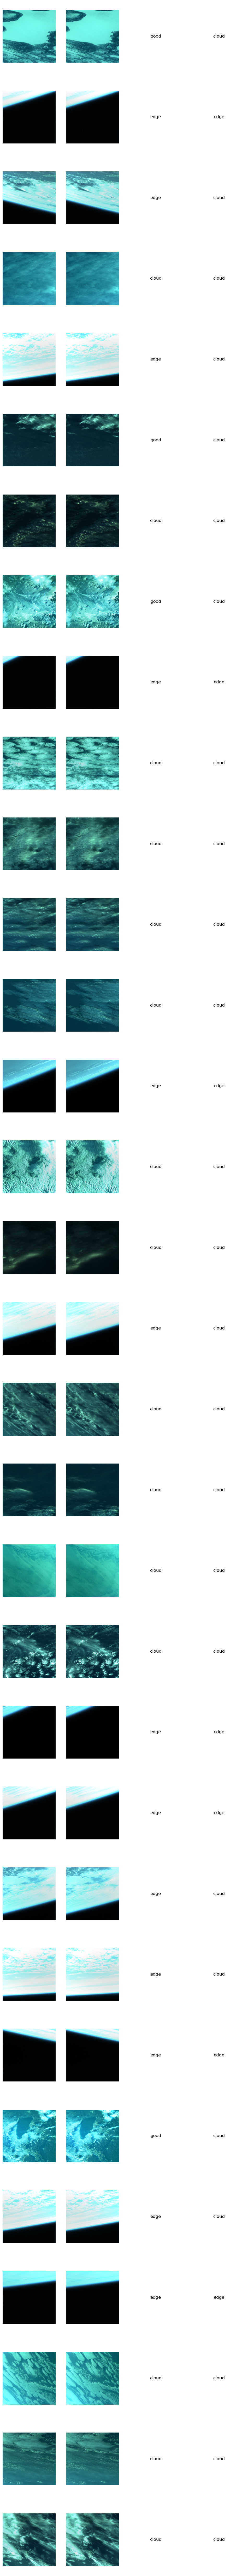

In [52]:
fig, axs = plt.subplots(batch_size, 4, figsize=(12, 4 * batch_size))



for i in range(len(images_norm_VAL)):
    og_img = tensor_to_numpy(images_og_VAL[i])
    norm_img = tensor_to_numpy(images_norm_VAL[i])
    
    axs[i, 0].imshow(og_img)
    axs[i, 0].axis('off')

    # Plot the second image
    axs[i, 1].imshow(norm_img)  # Assuming there are always pairs of images
    axs[i, 1].axis('off')

    # Plot the first text box
    axs[i, 2].text(0.5, 0.5, classes[labels_norm_VAL[i]], ha='center', va='center', fontsize=12, color='black')
    axs[i, 2].axis('off')

    # Plot the second text box
    axs[i, 3].text(0.5, 0.5, str(predictions[i]), ha='center', va='center', fontsize=12, color='black')
    axs[i, 3].axis('off')
# plt.tight_layout()
plt.show()